In [169]:
HOME_DIR = "/home_remote"
HOME = "/home/thi.tra.my.nguyen"

from liwc import Liwc
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import word_tokenize, ngrams
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
#import logisitic_regression
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Data preparation

In [238]:
positives_df_path = os.path.join(HOME_DIR, "positive_df.pkl")
negatives_df_path = os.path.join(HOME_DIR, "negative_df.pkl")

positives = pd.read_pickle(positives_df_path)
negatives = pd.read_pickle(negatives_df_path)

In [2]:
def construct_liwc_input(df, label):
  """
  params: df - The positive/negative dataframe loaded from pickle
    The df is expected to has these columns "Title", "Date", "Text", "SubjectId"
  params: label - The label need to be assigned to result dataframe

  returns: A dataframe contains "SubjectId", "AverageLength", "Text", "NumOfWritings", "Title"
  """
  subject_id_list = df.loc[:, "TrainSubjectId"].unique()

  df['text'] = df['Text']+ df['Title']
  
  df["Token"] = df["text"].apply(lambda x: word_tokenize(x))
  df["LWR"] = df['text'].apply(lambda x: textstat.linsear_write_formula(x))
  df["FRE"] = df['text'].apply(lambda x: textstat.flesch_reading_ease(x))
  df["DCR"] = df['text'].apply(lambda x: textstat.dale_chall_readability_score(x))
  df["FOG"] = df['text'].apply(lambda x: textstat.gunning_fog(x))

  grouped_by_subject_id = df.groupby('TrainSubjectId')

  # calculate average token length for each user
  average_length_df = grouped_by_subject_id['Token'].apply(lambda token_series: sum(len(token) for token in token_series) / len(token_series)).reset_index()
  average_length_df.rename(columns={'Token': 'AverageLength'}, inplace=True)
  #print(average_length_df.head())

  # join all writings of single user into single corpus
  joined_text_df = grouped_by_subject_id['text'].apply(' '.join).reset_index()

  # calculate number of writings for each user
  number_of_writings_df = grouped_by_subject_id['Text'].apply(lambda x: len(x)).reset_index()
  number_of_writings_df.rename(columns={'Text': 'NumOfWritings'}, inplace=True)

  result_df = average_length_df.merge(joined_text_df, on="TrainSubjectId")
  result_df = result_df.merge(number_of_writings_df, on="TrainSubjectId")
  result_df["Label"] = label

  return result_df

In [5]:
input_positives = construct_liwc_input(positives, 1)
input_negatives = construct_liwc_input(negatives, 0)

In [6]:
liwc_input = pd.concat([input_positives, input_negatives])
liwc_input = liwc_input.sample(frac=1).reset_index(drop=True)

In [228]:
data_input = liwc_input[['TrainSubjectId', 'Label', 'text']]

### Hand-crafted features

In [221]:
pip install textstat

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.7 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [225]:
import textstat

In [239]:
positives['text'] = positives['Text']+ positives['Title']
  
positives["Token"] = positives["text"].apply(lambda x: word_tokenize(x))
positives["LWF"] = positives['text'].apply(lambda x: textstat.linsear_write_formula(x))
positives["FRE"] = positives['text'].apply(lambda x: textstat.flesch_reading_ease(x))
positives["DCR"] = positives['text'].apply(lambda x: textstat.dale_chall_readability_score(x))
positives["FOG"] = positives['text'].apply(lambda x: textstat.gunning_fog(x))
positives["ARI"] = positives['text'].apply(lambda x: textstat.automated_readability_index(x))
positives["SMOG"] = positives['text'].apply(lambda x: textstat.smog_index(x))
positives[]  textstat.avg_sentence_length(text)

In [240]:
negatives['text'] = negatives['Text']+ negatives['Title']
negatives["Token"] = negatives["text"].apply(lambda x: word_tokenize(x))
negatives["LWF"] = negatives['text'].apply(lambda x: textstat.linsear_write_formula(x))
negatives["FRE"] = negatives['text'].apply(lambda x: textstat.flesch_reading_ease(x))
negatives["DCR"] = negatives['text'].apply(lambda x: textstat.dale_chall_readability_score(x))
negatives["FOG"] = negatives['text'].apply(lambda x: textstat.gunning_fog(x))


In [243]:
positives_mean = positives.groupby('TrainSubjectId').agg({'LWF': 'mean', 'FRE': 'mean', 'DCR': 'mean', 'FOG': 'mean'}).reset_index()
negatives_mean = negatives.groupby('TrainSubjectId').agg({'LWF': 'mean', 'FRE': 'mean', 'DCR': 'mean', 'FOG': 'mean'}).reset_index()
positives_mean['Label'] = 1
negatives_mean['Label'] = 0
#concat
handcrafted = pd.concat([positives_mean, negatives_mean])

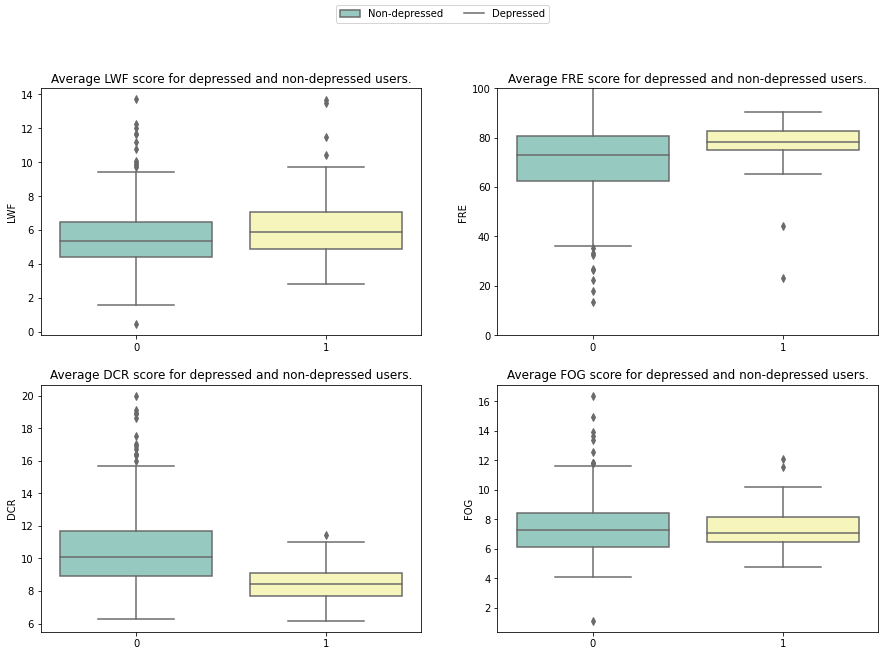

In [285]:
#plot boxplot for each feature in both negative and positive in the same figure. 0 is non-depressed, 1 is depressed
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(x="Label", y="LWF", data=handcrafted, ax=ax[0, 0], palette="Set3")
#rescale the y axis
ax[0, 1].set_ylim(0, 100)
sns.boxplot(x="Label", y="FRE", data=handcrafted, ax=ax[0, 1], palette="Set3")
sns.boxplot(x="Label", y="DCR", data=handcrafted, ax=ax[1, 0], palette="Set3")
sns.boxplot(x="Label", y="FOG", data=handcrafted, ax=ax[1, 1], palette="Set3")

#cancel the x label
ax[0, 0].set(xlabel=None)
ax[0, 1].set(xlabel=None)
ax[1, 0].set(xlabel=None)
ax[1, 1].set(xlabel=None)

#title
ax[0, 0].set_title('Average LWF score for depressed and non-depressed users.')
ax[0, 1].set_title('Average FRE score for depressed and non-depressed users.')
ax[1, 0].set_title('Average DCR score for depressed and non-depressed users.')
ax[1, 1].set_title('Average FOG score for depressed and non-depressed users.')

#legend
fig.legend(labels=['Non-depressed', 'Depressed'], loc='upper center', ncol=2)

#plt.savefig(os.path.join(HOME_DIR, "handcrafted_features.pdf"))
plt.show()


### Feature Extraction

In [8]:
# Load LIWC dictionary
liwc = Liwc(os.path.join(HOME_DIR, "master_thesis/LIWC2007_English100131.dic"))
input = [liwc.parse(word_tokenize(text)) for text in data_input['text']]

In [9]:
# Load LIWC-alike dictionary
%run /home_remote/master_thesis/model_evaluation/liwc_alike.py
liwc_alike_output = [main(text, result) for text in data_input['text']]

In [160]:
#extract top 15 features based on percentage. 
def get_features_top15(df, output):
    #df['vector'] = output
    vector_df = pd.DataFrame(output, index=df.index)
    vector_df_norm = vector_df.div(vector_df.sum(axis=1), axis=0)
    vector_df_norm['Label'] = df['Label']
    vector_df_norm['TrainSubjectId'] = df['TrainSubjectId']
    vector_df_norm = vector_df_norm.fillna(0)
    corr = vector_df_norm.corr()
    corr_label = corr['Label'].sort_values(ascending=False)
    relevant_features = corr_label[1:40]
    relevant_features_name = relevant_features.index.values
    X = vector_df_norm[relevant_features_name]
    y = vector_df_norm['Label']
    return X, y

In [161]:
X_liwc_alike_15, y_liwc_alike_15 = get_features_top15(data_input, liwc_alike_output)

In [206]:
#using chi2 to extract top 15 features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
def get_features_chi2(df, output):
    vector_df = pd.DataFrame(output, index=df.index)
    vector_df_norm = vector_df.div(vector_df.sum(axis=1), axis=0)
    vector_df_norm['Label'] = df['Label']
    vector_df_norm['TrainSubjectId'] = df['TrainSubjectId']
    vector_df_norm = vector_df_norm.fillna(0)
    X = vector_df_norm.drop(['Label', 'TrainSubjectId'], axis=1)
    y = vector_df_norm['Label']
    X_new = SelectKBest(chi2, k=4).fit_transform(X, y)
    return X_new, y

In [218]:
#extraction using mutual information
from sklearn.feature_selection import mutual_info_classif
def get_features_mutual_info(df, output):
    vector_df = pd.DataFrame(output, index=df.index)
    vector_df_norm = vector_df.div(vector_df.sum(axis=1), axis=0)
    vector_df_norm['Label'] = df['Label']
    vector_df_norm['TrainSubjectId'] = df['TrainSubjectId']
    vector_df_norm = vector_df_norm.fillna(0)
    X = vector_df_norm.drop(['Label', 'TrainSubjectId'], axis=1)
    y = vector_df_norm['Label']
    X_new = SelectKBest(mutual_info_classif, k=15).fit_transform(X, y)
    return X_new, y

In [207]:
X_alike_chi_15, y_alike_chi_15 = get_features_chi2(data_input, liwc_alike_output)

In [219]:
X_alike_mutual_15, y_alike_mutual_15 = get_features_mutual_info(data_input, liwc_alike_output)

### Models

In [113]:
def logistic_regression(X, y):

    w = [1, 2**1, 2**2, 2**3, 2**4, 2**5, 2**6,2**7, 2**8]
    weight = [{0: 1/(1+x),  1: x/(1+x)} for x in w]
    C = [2**-6, 2**-5, 2**-4, 2**-3, 2**-2, 2**-1, 1, 2**1, 2**2, 2**3, 2**4, 2**5, 2**6]
    # define grid search
    hyperparam_grid = {"class_weight": weight
                    ,"C": C
                    ,"fit_intercept": [True, False]  }
    # define evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=13)
    # define grid search
    model_test = LogisticRegression(solver='liblinear', penalty='l1')
    grid = GridSearchCV(estimator=model_test, param_grid=hyperparam_grid, cv=cv, scoring='f1')
    grid_result = grid.fit(X, y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    #build a model with the best parameters, fix class_weight = (0.2, 0.8)

    model = LogisticRegression(**grid_result.best_params_)
    model.fit(X, y)
    return model

### PCA

In [128]:
a = pd.DataFrame(liwc_alike_output, index=data_input.index)
b = a.div(a.sum(axis=1), axis=0)
b = b.fillna(0)

In [137]:
#save pca model
pca = PCA(n_components=15)
pca.fit(b)
c = pca.transform(b)
#joblib.dump(pca, os.path.join(HOME_DIR,'pca.pkl'))

In [162]:
model_pca = logistic_regression(c, data_input['Label'])
y_pred_pca = model_pca.predict(c)
print(classification_report(data_input['Label'], y_pred_pca))

Best: 0.610030 using {'C': 64, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': True}
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       403
           1       0.48      0.65      0.55        83

    accuracy                           0.82       486
   macro avg       0.70      0.75      0.72       486
weighted avg       0.85      0.82      0.83       486



In [164]:
joblib.dump(model_pca, os.path.join(HOME_DIR,'model_pca_liwc_alike.pkl'))

['/home_remote/model_pca_liwc_alike.pkl']

### Test with LR

In [159]:
model = logistic_regression(X_liwc_alike_15, y_liwc_alike_15)
y_pred_15 = model.predict(X_liwc_alike_15)
print(classification_report(y_liwc_alike_15, y_pred_15))

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best: 0.621761 using {'C': 64, 'class_weight': {0: 0.3333333333333333, 1: 0.6666666666666666}, 'fit_intercept': True}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       403
           1       0.65      0.13      0.22        83

    accuracy                           0.84       486
   macro avg       0.75      0.56      0.57       486
weighted avg       0.81      0.84      0.79       486



In [208]:
#test with X_alike_chi_15
model_chi = logistic_regression(X_alike_chi_15, y_alike_chi_15)
y_pred_15_chi = model_chi.predict(X_alike_chi_15)
print(classification_report(y_pred_15_chi, y_alike_chi_15))

Best: 0.585963 using {'C': 64, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': True}
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       380
           1       0.60      0.47      0.53       106

    accuracy                           0.82       486
   macro avg       0.73      0.69      0.71       486
weighted avg       0.80      0.82      0.81       486



In [220]:
#test with X_alike_mutual_15
model_mutual = logistic_regression(X_alike_mutual_15, y_alike_mutual_15)
y_pred_15_mutual = model_mutual.predict(X_alike_mutual_15)
print(classification_report(y_pred_15_mutual, y_alike_mutual_15))

Best: 0.605273 using {'C': 16, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': False}
              precision    recall  f1-score   support

           0       1.00      0.83      0.91       482
           1       0.04      0.75      0.07         4

    accuracy                           0.83       486
   macro avg       0.52      0.79      0.49       486
weighted avg       0.99      0.83      0.90       486



### Hand-crafted features

In [ ]:
positives['']

### LSTM

In [99]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Example text data (replace this with your actual text data)
texts = data_input['text'].tolist()
# Create a tokenizer and fit it on your text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# Get the vocabulary size
vocabulary_size = len(tokenizer.word_index) + 1  # Add 1 for the special padding token if used

print("Vocabulary Size:", vocabulary_size)

Vocabulary Size: 165172


In [101]:
X_train, X_test, y_train, y_test = train_test_split(c, data_input['Label'], test_size=0.2, random_state=13)

In [108]:
#lstm 
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the model
model2 = Sequential()

# Embedding layer
model2.add(Embedding(input_dim = 15 , output_dim =128))

# LSTM layer with ReLU activation and dropout
model2.add(LSTM(128, activation='relu', dropout=0.3, recurrent_dropout=0.3))

# Fully connected layer with ReLU activation
model2.add(Dense(128, activation='relu', kernel_regularizer='l2', bias_regularizer='l2'))

# Dropout layer
model2.add(Dropout(0.3))

# Output layer with softmax activation for binary classification
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

# Learning rate decay scheduler
def lr_scheduler(epoch, lr):
    return lr * np.exp(-1e-5 * epoch)

lr_callback = LearningRateScheduler(lr_scheduler)

# Train the model
model2.fit(X_train, y_train, epochs=130, batch_size=100, callbacks=[lr_callback], class_weight={0: 0.2, 1: 0.8})

2023-11-13 23:44:56.661048: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.5KiB (rounded to 7680)requested by op RandomUniform
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-11-13 23:44:56.661127: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2023-11-13 23:44:56.661156: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 4, Chunks in use: 3. 1.0KiB allocated for chunks. 768B in use in bin. 16B client-requested in use in bin.
2023-11-13 23:44:56.661178: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-11-13 23:44:56.661199: I tensorflow/core/common_runt

ResourceExhaustedError: OOM when allocating tensor with shape[15,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]